# Logistic Regression Modeling and Metrics With Count Vectorier
---

## Contents
---
- [Library and Data Imports](#Library-and-Data-Imports)
- [Train Test Split and Base Model](#Train-Test-Split-and-Base-Model)
- [Logistic Regression with Count Vectorizer](#Logistic-Regression-with-Count-Vectorizer)
- [Predictions and Interpretation](#Predictions-and-Interpretation)
- [Confusion Matrix Interpretation](#Confusion-Matrix-Interpretation)

## Library and Data Imports

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler


**Read in text_processed_corpus.csv**

In [40]:
text_processed_corpus = pd.read_csv('./data/text_processed_corpus.csv')

In [42]:
text_processed_corpus

,subreddit,processed_text
0,1,traveling journal fountainpens approve moderat...
1,1,need simple reminder
2,1,confess wrong kaweco hobby decade especially l...
3,1,cheap fountain pen well cheap pen zero problem...
4,1,literally classic design beautiful stripe engr...
...,...,...
2791,0,pen pick
2792,0,want pen idea
2793,0,look id left pen image find
2794,0,current rotation complaint


## Train Test Split and Base Model
___

In [3]:
#Train Test Split
X = text_processed_corpus['processed_text']
y = text_processed_corpus['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    stratify = y,
                                                    random_state = 24)
                                                    
    

**What is the base model?**
* There is a **56%** chance of correctly predicting a post belongs in the fountainpens reddit.

In [4]:
y.value_counts(normalize = True) * 100

subreddit
1    55.615165
0    44.384835
Name: proportion, dtype: float64

In [5]:
#Ensuring that stratify is maintaining the slight skew between the two subreddit
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(subreddit
 1    0.556032
 0    0.443968
 Name: proportion, dtype: float64,
 subreddit
 1    0.556509
 0    0.443491
 Name: proportion, dtype: float64)

In [6]:
# Summon the vectorizers and estimators
cvec = CountVectorizer()
logreg = LogisticRegression()

## Logistic Regression with Count Vectorizer
___

Results - Model resulted in 87% accuracy with testing data compared to 98% with training data.  I would consider this model overfit.

In [7]:
# Build a pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [8]:
# Checking an initial score without actually fitting anything.
cross_val_score(pipe, X_train, y_train, cv=3).mean()

0.8512160228898425

In [9]:
# Create parameters for a gridsearch over to see what performs best -  Started with2100 total models not including cv.
# Varied parameters until ideal parameters were determined.
pipe_params = {
    'cvec__max_features': [10000, 11000, 12000], 
    'cvec__min_df': [0.001, 0.005,0.01], 
    'cvec__max_df': [0.7, 0.8, 0.9], 
    'cvec__ngram_range': [(1,1), (1,2)],
    'logreg__C': [1.0, 0.1, 0.01],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear']
}
    

In [10]:
#GridSearch set-up
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5)

In [11]:
#GridSearch the training data.

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.7, 0.8, 0.9],
                         'cvec__max_features': [10000, 11000, 12000],
                         'cvec__min_df': [0.001, 0.005, 0.01],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'logreg__C': [1.0, 0.1, 0.01],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear']})

Performed lots of tuning on CountVectorizer and Logistic Regression parameters, but the best score didn't improve beyond 87%

In [12]:
#What was the best score?
print(f'The best accuracy score in all models tested in grid search is {round(gs.best_score_,2) * 100}%')

The best accuracy score in all models tested in grid search is 87.0%


In [13]:
# Breakdown of the parameters chosen to make the best model.  Liblinear was the only option added to pipe parameters.
gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 10000,
 'cvec__min_df': 0.001,
 'cvec__ngram_range': (1, 2),
 'logreg__C': 1.0,
 'logreg__penalty': 'l2',
 'logreg__solver': 'liblinear'}

## Predictions and Interpretation
___
Results - Model resulted in 89% accuracy with testing data compared to 98% with training data.

In [14]:
#Training set results
print(f'Training accuracy score is at {round(gs.score(X_train, y_train),2) * 100}%')

Training accuracy score is at 98.0%


In [15]:
# Testing set results is at 89% - Null model is at 56%
print(f'Testing accuracy score is at {round(gs.score(X_test, y_test),2) * 100}%')

Testing accuracy score is at 89.0%


In [16]:
# The next two slides show how the model predicts (fountainpens = 1 and pens = 0) and the probability for each row value.
# First 20 samples are shown.
pred = gs.predict(X_test)
pred[:20]

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
      dtype=int64)

In [17]:
gs.predict_proba(X_test)[:20]

array([[8.54137821e-01, 1.45862179e-01],
       [2.69648693e-04, 9.99730351e-01],
       [2.34946107e-01, 7.65053893e-01],
       [7.48927142e-02, 9.25107286e-01],
       [9.48848334e-01, 5.11516655e-02],
       [3.91599132e-01, 6.08400868e-01],
       [5.85553774e-01, 4.14446226e-01],
       [1.09774618e-01, 8.90225382e-01],
       [1.44116598e-01, 8.55883402e-01],
       [1.65783294e-02, 9.83421671e-01],
       [4.13693724e-09, 9.99999996e-01],
       [2.97989049e-01, 7.02010951e-01],
       [2.37789684e-04, 9.99762210e-01],
       [6.50084916e-01, 3.49915084e-01],
       [1.29830076e-03, 9.98701699e-01],
       [9.04887948e-01, 9.51120519e-02],
       [3.20168783e-01, 6.79831217e-01],
       [3.85832486e-03, 9.96141675e-01],
       [1.33537855e-01, 8.66462145e-01],
       [9.84194293e-02, 9.01580571e-01]])

In [18]:
# Accuracy Score - What precentage of total predictions were correct?
print(f'This model has an accuracy score of {round(metrics.accuracy_score(y_test, pred) * 100,2)}%')

This model has an accuracy score of 89.41%


## Confusion Matrix Interpretation
---

In this scenerio, I would ideally prefer to never incorrectly classify a pen subreddit post as a fountainpens post.  Pens are a more general topic and talking about fountain pens would be acceptable.  It's safe to assume people browsing the fountainpens subreddit are only interested in fountain pens.<br><br>
Essentially I want to mimimize false positives.  **The specificity score is ~87%** and this model handles false positives a bit better than false negatives.

In [19]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

print(tn, fp, fn, tp)

269 41 33 356


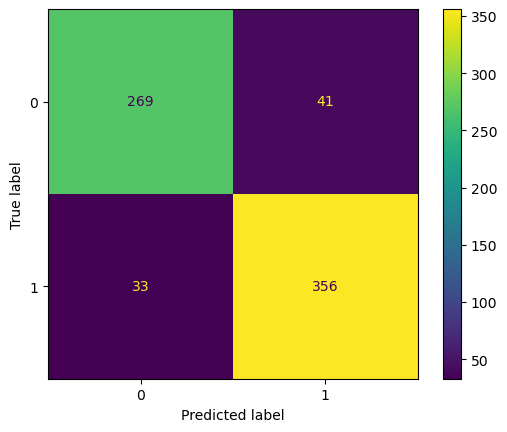

In [20]:
#Create a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred),
                             display_labels=gs.classes_)

disp.plot();

In [21]:
# How sensitive is this model?
metrics.recall_score(y_test, pred)

0.9151670951156813

In [22]:
# What is the specificity of the model?  - I care about this metric more, but unfortunately doesn't do as well here.
tn / (tn + fp)

0.867741935483871

In [23]:
# Recall is the same as sensitivity and is a good indicator for false negatives
metrics.recall_score(y_test, pred)

0.9151670951156813

In [24]:
# Precision score.  How many were correctly predicted to go in the fountainpens reddit?
metrics.precision_score(y_test, pred)

0.8967254408060453

<Figure size 2000x800 with 0 Axes>

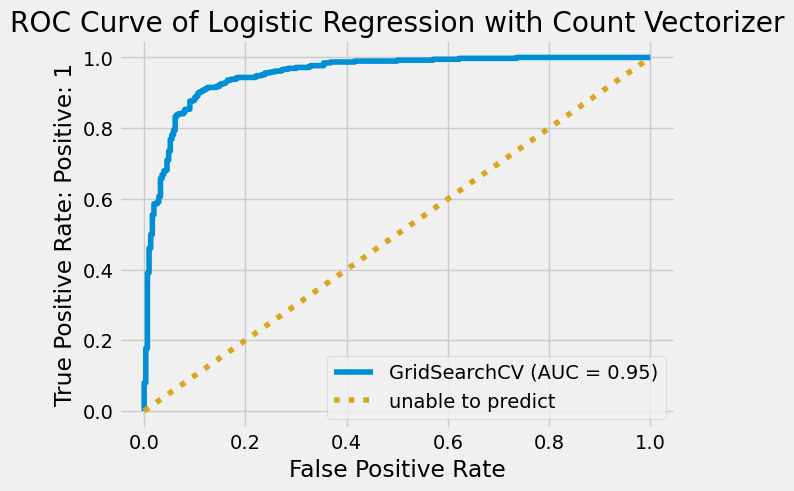

In [27]:
plt.figure(figsize = (20,8))
plt.style.use("fivethirtyeight")
plt.tight_layout()

RocCurveDisplay.from_estimator(gs, X_test, y_test)

# The 50/50 line
plt.plot([0,1], [0,1],
         label = 'unable to predict',
         linestyle = 'dotted',
         color = 'goldenrod');

# Legend
plt.legend()
plt.title('ROC Curve of Logistic Regression with Count Vectorizer')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate: Positive: 1')
plt.savefig('./plot_images/logreg_cvec_roc_curve.png', dpi = 192);